# Lab 3


In [ ]:
"""
Created by:  Charity Grey (2025)
Modified by:  [Your Name] (2025)
"""


# Install required packages if needed
# !pip install SimpleITK torch torchio
from tcia_utils import nbia
import pandas as pd
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt

### DICOM

DICOM is Digital Imaging and Communications in Medicine — is the international standard for medical images and related information
- OPTIONAL 10 min video: just for ur knowledge https://www.youtube.com/watch?v=-c9KhcGYTG4 

### Visit The Cancer Imaging Archive (TCIA)
Skim this: https://www.cancerimagingarchive.net/browse-collections/ 

#### Download the data using their web API

Q: What is an API? Watch this 3 min video to understand:
https://www.youtube.com/watch?v=-0MmWEYR2a8 

Ans: An application programming interface is a connection between computers or between computer programs. It is a type of software interface, offering a service to other pieces of software


#### How to use APIs? 

- In bioinformatics, a lot of APIs are used for downloading and accessing data
- Each api is different, but you always make some sort of a request. ie: in English, the request "Where" tells you the answer you want is a location.

How you format your request can achieved via reading documention for that API.

Our reference documentation here:
- https://wiki.cancerimagingarchive.net/display/Public/TCIA+Programmatic+Interface+%28REST+API%29+Usage+Guide+v2 
- if you would like to follow their optional tutorial: https://github.com/kirbyju/TCIA_Notebooks/blob/main/TCGA/TCGA_Clinical.ipynb 


### YOU ARE NOT EXPECTED TO REPRODUCE THIS. JUST READ IT AND TRY TO FOLLOW ALONG AS YOU RUN THE CELLS

The reason why is because sometimes, bioinformatics processes are NOT just about analysis. It's also about getting the data and cleaning it/manipulating it to be in the right format for analysis
- this is called data engineering (data wrangling if you are more in data science)

In [36]:
# get list of all collections
collections_json = nbia.getCollections()
print(str(len(collections_json)) + " collections were found.")
collections = [item['Collection'] for item in collections_json]
print('Collections: ', collections)
collections = ['PROSTATE-DIAGNOSIS']

series_df = nbia.getSeries(collections[0], format="df")

print("Series DataFrame shape:", series_df.shape)
series_df.head(1)

2025-09-25 18:50:30,625:INFO:Calling getCollectionValues with parameters {}
2025-09-25 18:50:36,523:INFO:Calling getSeries with parameters {'Collection': 'PROSTATE-DIAGNOSIS'}


149 collections were found.
Collections:  ['4D-Lung', 'A091105', 'ACNS0332', 'ACRIN-6698', 'ACRIN-Contralateral-Breast-MR', 'ACRIN-FLT-Breast', 'ACRIN-HNSCC-FDG-PET-CT', 'ACRIN-NSCLC-FDG-PET', 'AHEP0731', 'AHOD0831', 'ARAR0331', 'AREN0532', 'AREN0533', 'AREN0534', 'Adrenal-ACC-Ki67-Seg', 'Advanced-MRI-Breast-Lesions', 'Anti-PD-1_Lung', 'B-mode-and-CEUS-Liver', 'BREAST-DIAGNOSIS', 'Breast-Cancer-Screening-DBT', 'Breast-MRI-NACT-Pilot', 'C4KC-KiTS', 'CALGB50303', 'CBIS-DDSM', 'CC-Radiomics-Phantom', 'CC-Radiomics-Phantom-2', 'CC-Radiomics-Phantom-3', 'CC-Tumor-Heterogeneity', 'CMB-AML', 'CMB-BRCA', 'CMB-CRC', 'CMB-GEC', 'CMB-LCA', 'CMB-MEL', 'CMB-MML', 'CMB-OV', 'CMB-PCA', 'CMMD', 'COVID-19-AR', 'COVID-19-NY-SBU', 'CPTAC-AML', 'CPTAC-CCRCC', 'CPTAC-CM', 'CPTAC-LSCC', 'CPTAC-LUAD', 'CPTAC-PDA', 'CPTAC-SAR', 'CPTAC-UCEC', 'CT COLONOGRAPHY', 'CT Lymph Nodes', 'CT-Phantom4Radiomics', 'CT-vs-PET-Ventilation-Imaging', 'CT4Harmonization-Multicentric', 'CTpred-Sunitinib-panNET', 'Colorectal-Live

,SeriesInstanceUID,StudyInstanceUID,Modality,ProtocolName,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,...,ImageCount,TimeStamp,LicenseName,LicenseURI,CollectionURI,FileSize,DateReleased,StudyDesc,StudyDate,ThirdPartyAnalysis
0,1.3.6.1.4.1.14519.5.2.1.4792.2002.115178120278...,1.3.6.1.4.1.14519.5.2.1.4792.2002.269119633629...,MR,T2W_TSE_COR SENSE,2008-09-23 00:00:00.0,T2W_TSE_COR,PROSTATE,401,PROSTATE-DIAGNOSIS,ProstateDx-01-0001,...,24,2012-03-12 10:19:02.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2015.FOQEUJVT,3229344,2013-01-30 00:00:00.0,MRI PROSTATE WITH AND WITHOUT CONTRAST,2008-09-23 00:00:00.0,NaN


In [37]:
try:
    series_uid = series_df['SeriesInstanceUID'].iloc[0]
    bodyPart = series_df['BodyPartExamined'].iloc[0] 
    print(f"\nAttempting to download series for body part - {bodyPart}: {series_uid}")
    
    # Download with more specific parameters
    nbia.downloadSeries(
        [series_uid], 
        number=1, 
        input_type="list",
        path="./downloads"  # Specify download directory
    )
    print("Download completed successfully!")
    
except Exception as e:
    print(f"Download failed: {e}")

2025-09-25 18:51:18,584:INFO:Directory './downloads' already exists.
2025-09-25 18:51:18,586:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.4792.2002.115178120278427420002997506613 already downloaded and unzipped.
2025-09-25 18:51:18,587:INFO:Found 0 previously downloaded series.
2025-09-25 18:51:18,588:INFO:Attempting to download 0 new series.
2025-09-25 18:51:18,590:INFO:Downloaded 0 out of 0 targeted series.
0 failed to download.
0 were previously downloaded.



Attempting to download series for body part - PROSTATE: 1.3.6.1.4.1.14519.5.2.1.4792.2002.115178120278427420002997506613
Download completed successfully!


## 1. Loading Images with SimpleITK

In [16]:
# Method 1: Read a single DICOM file
try:
    # Load a single DICOM file
    folderpath = "./downloads/1.3.6.1.4.1.14519.5.2.1.4792.2002.115178120278427420002997506613/"
    image_path = f'{folderpath}1-01.dcm'  # Update with your image path
    image = sitk.ReadImage(image_path)
    print('Single DICOM Image size:', image.GetSize())
    print('Image spacing:', image.GetSpacing())
except:
    print("Single DICOM file not found")


Single DICOM Image size: (256, 256, 1)
Image spacing: (0.703125, 0.703125, 3.0)


In [21]:
# The following line will fail. Why?
# Ans: 
# SimpleITK has a build in Show method which saves the image to disk and launches a user configurable program ( defaults to ImageJ ), to display the image.


sitk.Show(image, title="image 1")

RuntimeError: Exception thrown in SimpleITK Show: D:\a\SimpleITK\SimpleITK\Code\IO\src\sitkImageViewer.cxx:758:
sitk::ERROR: No ImageJ/Fiji application found.

TypeError: Invalid shape (1, 256, 256) for image data

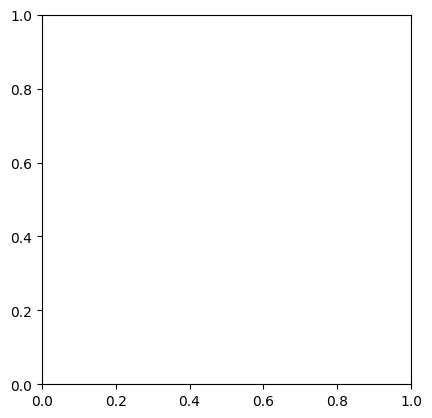

In [26]:
nda = sitk.GetArrayFromImage(image)
# The following line will fail. Why?
# Ans:

plt.imshow(nda)

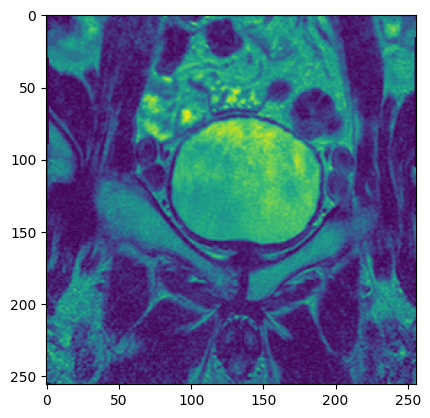

In [34]:
# Try this line:
plt.imshow(np.squeeze(nda)) 

In [13]:

# Method 2: Read DICOM series from a directory (recommended for 3D volumes)
try:
    dicom_directory = folderpath  # Directory containing DICOM files
    
    # Get the series IDs
    series_reader = sitk.ImageSeriesReader()
    series_IDs = series_reader.GetGDCMSeriesIDs(dicom_directory)
    
    if len(series_IDs) > 0:
        print(f"Found {len(series_IDs)} DICOM series")
        
        # Read the first series
        series_file_names = series_reader.GetGDCMSeriesFileNames(dicom_directory, series_IDs[0])
        series_reader.SetFileNames(series_file_names)
        image = series_reader.Execute()
        
        print('DICOM Series Image size:', image.GetSize())
        print('Image spacing:', image.GetSpacing())
        print('Image origin:', image.GetOrigin())
        print('Image direction:', image.GetDirection())
        print('Number of files in series:', len(series_file_names))
    else:
        print("No DICOM series found in directory")
        
except Exception as e:
    print(f"Error reading DICOM series: {e}")


Found 1 DICOM series
DICOM Series Image size: (256, 256, 24)
Image spacing: (0.703125, 0.703125, 2.9999999999999742)
Image origin: (-102.04013347625, -30.854515075683, 41.5915451049804)
Image direction: (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0)
Number of files in series: 24


In [ ]:

# Method 3: Read all DICOM files in a directory as individual images
try:
    dicom_dir = folderpath
    if os.path.exists(dicom_dir):
        dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
        if dcm_files:
            # Read first DICOM file found
            first_dcm = os.path.join(dicom_dir, dcm_files[0])
            image = sitk.ReadImage(first_dcm)
            print(f'Individual DICOM file: {dcm_files[0]}')
            print('Image size:', image.GetSize())
            print('Pixel type:', image.GetPixelIDTypeAsString())
        else:
            print("No .dcm files found")
    else:
        print("Downloads directory not found")
except Exception as e:
    print(f"Error: {e}")

C:\Users\Hello\anaconda3\envs\biomod\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
